# EIGSEP Image Fit

Aaron Parsons

In [35]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.image import imread
import torch
from transformers import pipeline
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
from eigsep_terrain.img import HorizonImage, PRM_ORDER
from eigsep_data.plot import terrain_plot
import healpy
import pymc as pm
import pytensor.tensor as pt
from pytensor.compile.ops import as_op
import os, sys, glob, tqdm
import multiprocessing as mp
import arviz, corner

%matplotlib widget

In [2]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [57]:
dem['platform'] = np.array([1648, 2024, 1796])

meta = {}
meta['0817'] = {
    'best_prms': ( 1732.31,  2069.73,   1760.89,  1.4682,  3.6963, -0.0521,  9849.36),  #[LOSS= 0.0378]
    'ant_px': (2*1366, 2*1221),
}
meta['0833'] = {
    'best_prms': ( 1611.38,  1847.62,   1659.85,  1.2062,  1.2401, -0.0250,  5072.38),  #[LOSS= 0.0254]
    'ant_px': (1606, 2700),
}

#meta['0834'] = {
#    'best_prms': ( 1642.45,  1887.80,   1678.94,  1.1787,  1.2417, -0.0310,  2933.66),  #[LOSS= 0.0685]
#    'ant_px': (1622, 2251),
#}

meta['0860'] = {
    #'best_prms': ( 1539.90,  1989.78,   1765.54,  1.5423,  0.6162,  0.1541,  2328.29),  #[LOSS= 0.0206]
    #'best_prms': ( 1538.80,  2001.28,   1765.46,  1.5411,  0.6109,  0.1589,  2328.29),  #[LOSS= 0.0166]
    'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0151]
    'ant_px': (2924, 1945),
}

for k in meta.keys():
    dem[k] = np.asarray(meta[k]['best_prms'][:3], dtype=np.float32)
    
files = sorted(glob.glob('/home/aparsons/Downloads/IMG_08*.jpg'))
#files = sorted(glob.glob('/home/aparsons/Downloads/IMG_08*.jpg'))[-1:]
print(files)
imgs = [HorizonImage(f, meta) for f in files]
imgs = [img for img in imgs if img.key in meta]

['/home/aparsons/Downloads/IMG_0817.jpg', '/home/aparsons/Downloads/IMG_0833.jpg', '/home/aparsons/Downloads/IMG_0834.jpg', '/home/aparsons/Downloads/IMG_0860.jpg']


In [58]:
dem.interp_alt(imgs[-1].prms['e'], imgs[-1].prms['n'])

np.int32(1758)

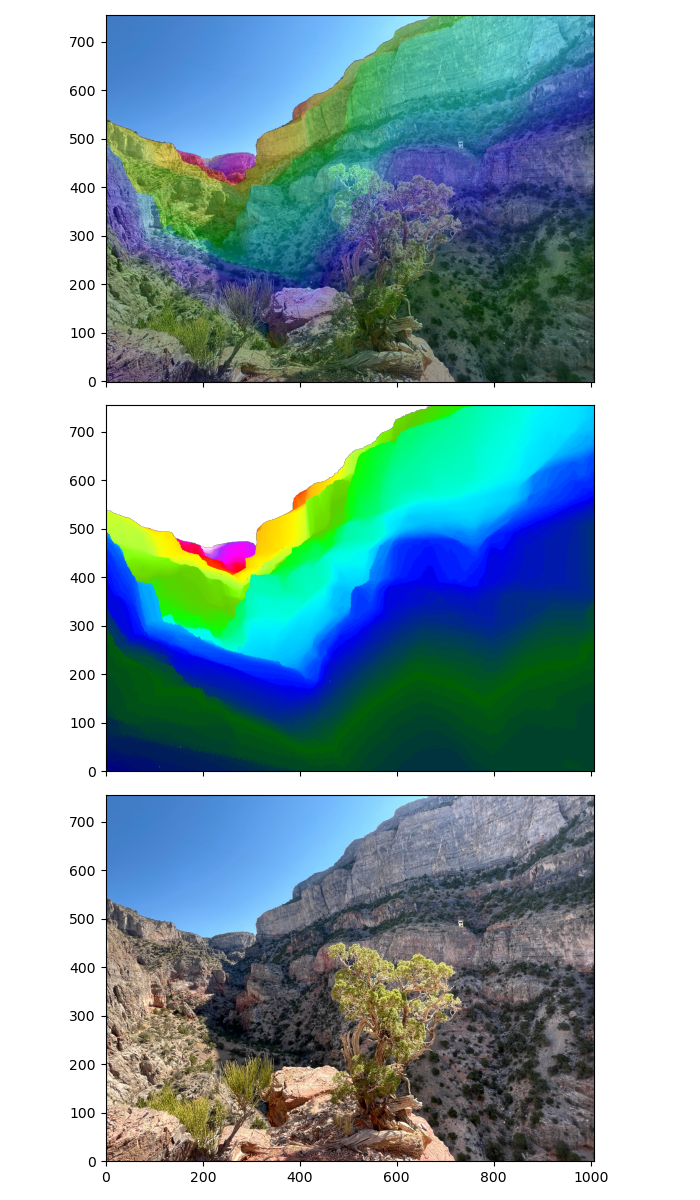

In [71]:
if True:
    fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(7, 4 * 3))
    r_imgs = {}
    sl = slice(None, None, 4)
    img = imgs[-1]
    axes[0].imshow(img.img[sl,sl], origin='lower')
    axes[2].imshow(img.img[sl,sl], origin='lower')
    r_imgs[img.key] = img.ray_distance(dem, img.get_rays()[...,sl,sl])
    axes[1].imshow(r_imgs[img.key], origin='lower', cmap='gist_ncar')
    axes[0].imshow(r_imgs[img.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()

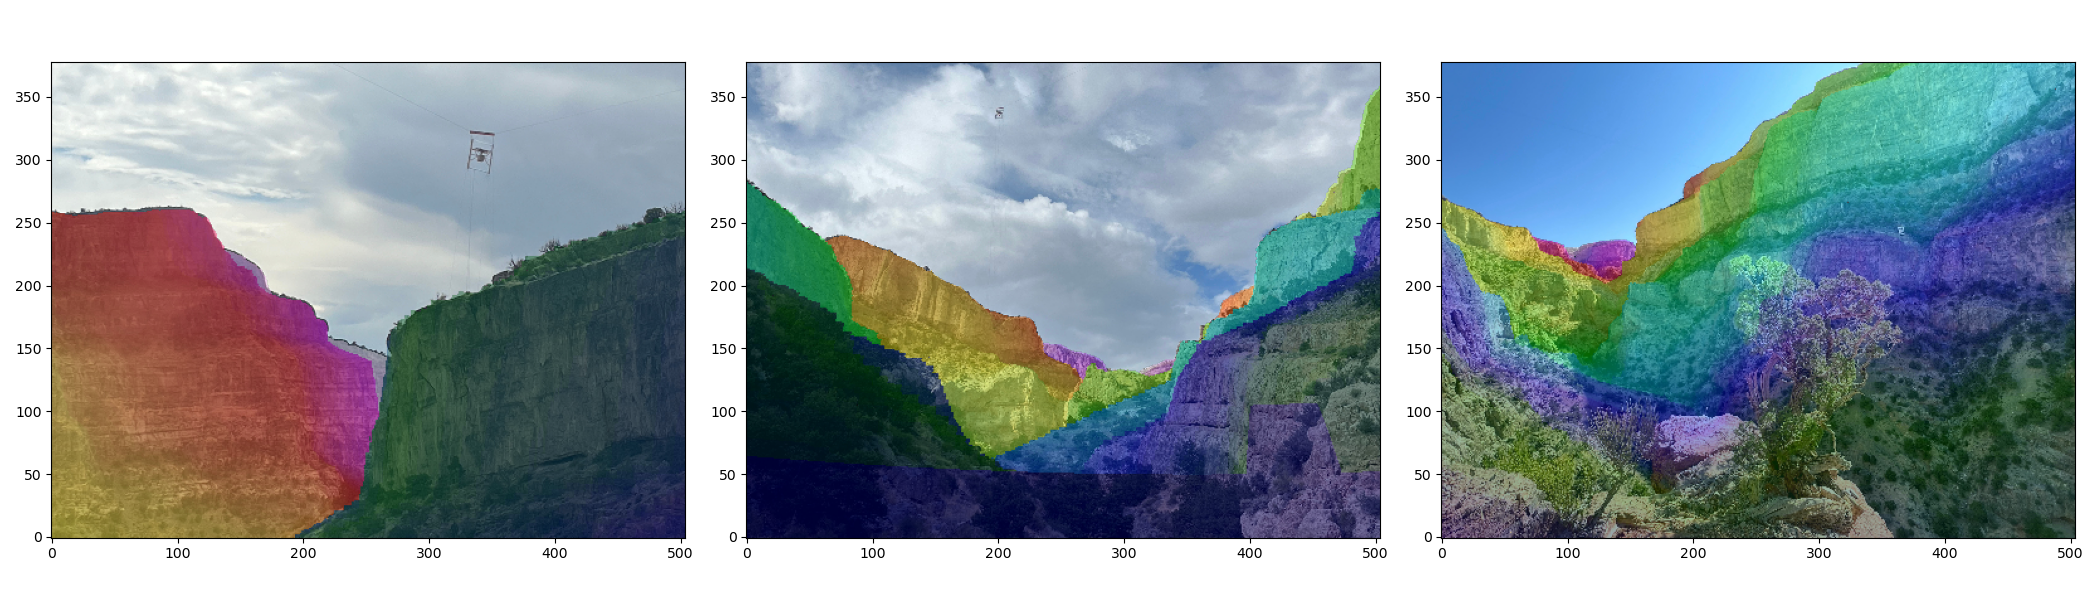

In [60]:
if True:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    r_imgs = {}
    sl = slice(None, None, 8)
    for cnt, img in enumerate(imgs):
        axes[cnt].imshow(img.img[sl,sl], origin='lower')
        r_imgs[img.key] = img.ray_distance(dem, img.get_rays()[...,sl,sl])
        axes[cnt].imshow(r_imgs[img.key], origin='lower', cmap='gist_ncar', alpha=0.4)
    plt.tight_layout()

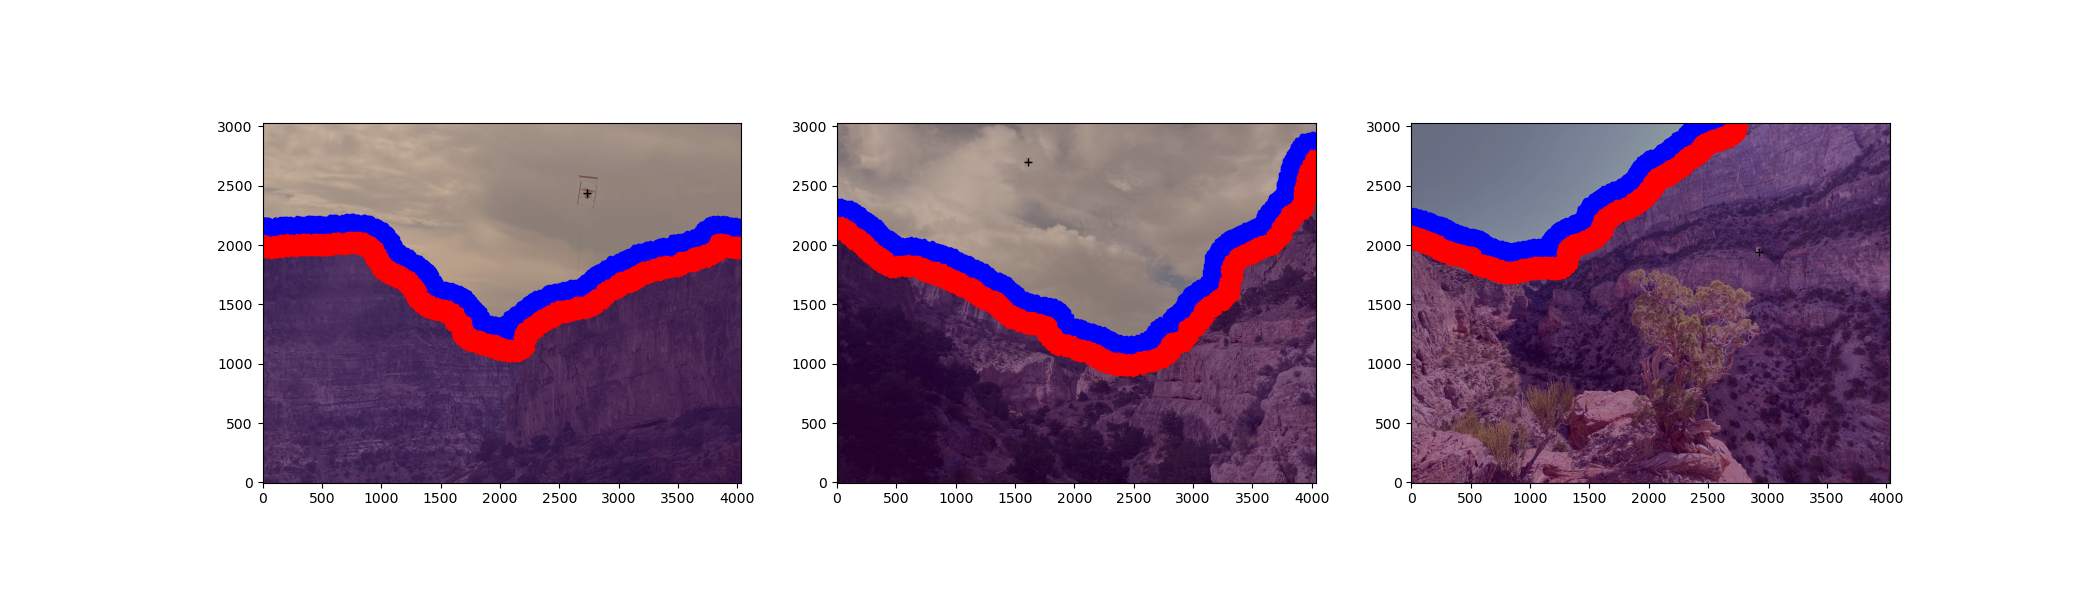

In [72]:
if True:
    fig, axes = plt.subplots(ncols=len(imgs), figsize=(7 * len(imgs), 6))
    if len(imgs) == 1:
        axes = [axes]
    for cnt, img in enumerate(imgs):
        axes[cnt].imshow(img.img, origin='lower')
        axes[cnt].imshow(img.sky_mask, origin='lower', alpha=0.3)
        axes[cnt].imshow(img.horizon_mask, origin='lower', alpha=0.3)
        x, y = img.choose_pixels(N=16000)
        is_sky = img.sky_mask[x, y]
        axes[cnt].plot(y[is_sky], x[is_sky], 'b.')
        axes[cnt].plot(y[~is_sky], x[~is_sky], 'r.')
        axes[cnt].plot(*img.meta['ant_px'], 'k+')

In [8]:
#nside = 512
##e0, n0, u0 = (1754, 2100, 1747)
#e0, n0, u0 = start_point = np.array((1767, 2095, 1759), dtype=float)
#rays = et.ray.healpix_rays(nside)
##e0, n0, u0 = start_point = np.array(dem['1P'], dtype=float)
##e0, n0, u0 = (0, 0, 1759)

In [9]:
#healpy.mollview(h.map)
#healpy.mollview(np.log10(ray_trace(start_point)), cmap='plasma')
#healpy.mollview(np.log10(r), cmap='plasma')
#healpy.mollview(np.log10(r2), cmap='plasma')
#healpy.mollview(T[-1], cmap='plasma')
#healpy.mollview((T_sky_full[:, 180]), cmap='plasma')

In [62]:
I = imgs[2]
I.reset_pixel_choice()
I.horizon_ray_loss(dem, cnt=16000);

'best_prms': ( 1540.51,  1998.55,   1766.85,  1.5421,  0.6131,  0.1584,  2328.30),  #[LOSS= 0.0158]


In [63]:
sigmas = (30.0, 30.0, 30.0, np.deg2rad(5.0), np.deg2rad(5.0), np.deg2rad(5.0), 0.1)

def make_sigmas(imgs):
    return [img.prms[k] * sig if sig == 'f' else sig for k, sig in zip(PRM_ORDER, sigmas) for img in imgs]

def build_model(img, dem, n_rays, eps=0.01):
    """
    eps: per-pixel error rate for mismatches (small)
    """
    @as_op(itypes=[pt.dvector], otypes=[pt.fscalar])
    def horizon_mismatches_loss(theta):
        L = 0.0
        for cnt, img in enumerate(imgs):
            img.set_prms(tuple(theta[cnt*len(PRM_ORDER):(cnt+1)*len(PRM_ORDER)]))
            L += img.horizon_ray_loss(dem, cnt=n_rays)
        return np.array(L / len(imgs), dtype=np.float32)

    with pm.Model() as model:
        prms = []
        sigmas = make_sigmas(imgs)
        for cnt, img in enumerate(imgs):
            _sigmas = sigmas[cnt*len(PRM_ORDER): (cnt+1)*len(PRM_ORDER)]
            prms += [pm.Normal(f"{img.key}_{k}", mu=img.prms[k], sigma=sig) for k, sig in zip(PRM_ORDER, _sigmas)]
        theta = pt.stack(prms)
        L = horizon_mismatches_loss(theta)
        # logp = (N - L)*log(1-eps) + L*log(eps)
        logp = len(imgs) * n_rays * (1 - L) * np.log(1.0 - eps) + len(imgs) * n_rays * L * np.log(eps)
        pm.Potential("lik", logp)

    return model

In [64]:
if False:
    with build_model(I, dem, n_rays=16000, eps=0.01) as model:
        step = pm.DEMetropolisZ(
            S=np.array(make_sigmas(imgs)),
            scaling=0.01,      # much bigger than 1e-3
            tune='scaling',   # let it adapt scale
            tune_interval=50, # adapt more often than default 100
        )
        
        trace = pm.sample(
            draws=500,
            tune=100,
            chains=4,
            step=step,
            cores=4,
            random_seed=42,
            progressbar=True,
        )
    arviz.to_netcdf(trace, f"{I.key}_trace.nc");
    print(f"Accepted step fraction = {float(trace.sample_stats.accepted.mean()): 4.3f}")

In [65]:
trace_files = sorted(glob.glob("*.nc"))
print(trace_files)
traces = {f.split('_')[0]: arviz.from_netcdf(f) for f in trace_files}

['0817_trace.nc', '0833_trace.nc', '0860_trace.nc']


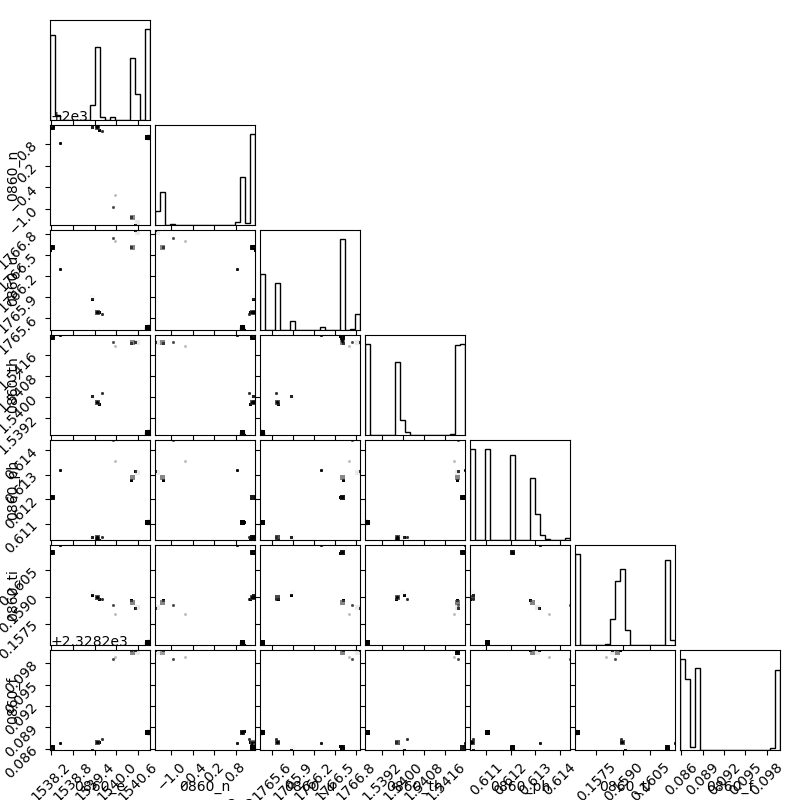

In [66]:
fig = plt.figure(figsize=(8, 8))
corner.corner(traces['0860'], fig=fig);

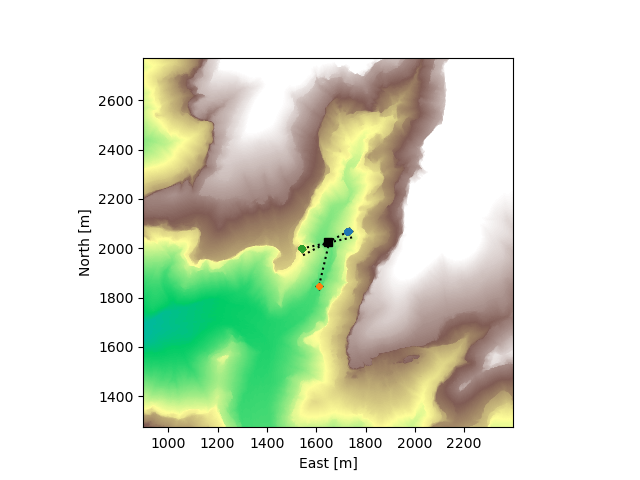

In [70]:
#e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
#u = dem.interp_alt(e, n)
#print(e, n, u)
fig, ax = plt.subplots()
e0, n0, u0 = dem['platform']
rng = 750
terrain_plot(dem, res=dem.res, ax=ax, vmin=u0-300, vmax=u0+200, erng_m=(e0-rng, e0+rng), nrng_m=(n0-rng, n0+rng))
plt.plot([e0], [n0], 's', color='k')
for img in imgs:
    e, n, u = img.prms['e'], img.prms['n'], img.prms['u']
    plt.plot([e], [n], '+', color='k')
    ant_ray = img.get_rays(pixels=np.array(img.meta['ant_px'][::-1]))
    plt.plot([e, e + ant_ray[0] * 220], [n, n + ant_ray[1] * 220], ':', color='k')
    trace = traces[img.key]
    try:
        plt.plot(np.asarray(trace.posterior[f'{img.key}_e']).flatten(), np.asarray(trace.posterior[f'{img.key}_n']).flatten(), '.');
    except(KeyError):
        plt.plot(np.asarray(trace.posterior['e']).flatten(), np.asarray(trace.posterior['n']).flatten(), '.');